In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# 1 - Load datasets

For brevity we assign letters to the four products: A=E-OBS, B=IMERG, C=OPERA, D=ERA5.

In [3]:
panel = (
    xr.open_dataset("./input/4CH_datasets_201610-202109.nc")
    .assign_coords({"product": ["EOBS", "IMERG", "OPERA", "ERA5"]})
    .assign_coords({"letter": ('product', ["A", "B", "C", "D"])})
)

In [4]:
panel.attrs = {}

In [5]:
panel

<xarray.Dataset>
Dimensions:  (lat: 400, lon: 600, product: 4, time: 1826)
Coordinates:
  * lat      (lat) float64 30.05 30.15 30.25 30.35 ... 69.65 69.75 69.85 69.95
  * lon      (lon) float64 -19.95 -19.85 -19.75 -19.65 ... 39.75 39.85 39.95
  * time     (time) datetime64[ns] 2016-10-01 2016-10-02 ... 2021-09-30
  * product  (product) <U5 'EOBS' 'IMERG' 'OPERA' 'ERA5'
    letter   (product) <U1 'A' 'B' 'C' 'D'
Data variables:
    tp       (product, time, lat, lon) float32 ...

# 2 - Compute the 4CH errors and other diagnostics

Compute percentage of data available for each product:

In [6]:
availability = 100 * (1 - panel.isnull().mean(dim="time"))

Make sure the variances are computed for the same dates across all pairs.
These dates can vary for each point. 
At each grid point we remove a date if it doesnt have data for the four products.

In [7]:
panel = panel.swap_dims({"product": "letter"})
loc = panel.isnull().any(dim=('letter'))
panel_completecases = panel.where(loc == False)

Remove points with less than 75% availability

In [8]:
mask = (1 - panel_completecases.isnull().mean(dim="time")) >= 0.75
panel_completecases = panel_completecases.where(mask, drop=True)

### Compute the mean differences between pairs of products
We employ all the data for computing biases, in this way we can see biases over the ocean when available.

In [9]:
x = panel
bias_ab = (x.sel(letter="A") - x.sel(letter="B")).mean(dim="time", skipna=True).compute()
bias_ac = (x.sel(letter="A") - x.sel(letter="C")).mean(dim="time", skipna=True).compute()
bias_ad = (x.sel(letter="A") - x.sel(letter="D")).mean(dim="time", skipna=True).compute()
bias_bc = (x.sel(letter="B") - x.sel(letter="C")).mean(dim="time", skipna=True).compute()
bias_bd = (x.sel(letter="B") - x.sel(letter="D")).mean(dim="time", skipna=True).compute()
bias_cd = (x.sel(letter="C") - x.sel(letter="D")).mean(dim="time", skipna=True).compute()

In [10]:
bias_panel = (
    xr.concat((bias_ab, bias_ac, bias_ad, bias_bc, bias_bd, bias_cd), dim="pair")
    .assign_coords({"pair": ["AB", "AC", "AD", "BC", "BD", "CD"]})
)

### Compute the difference variances of the six pairs of products

In [11]:
x = panel_completecases
var_ab = (x.sel(letter="A") - x.sel(letter="B")).var(dim="time", ddof=1, skipna=True).compute()
var_ac = (x.sel(letter="A") - x.sel(letter="C")).var(dim="time", ddof=1, skipna=True).compute()
var_ad = (x.sel(letter="A") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()
var_bc = (x.sel(letter="B") - x.sel(letter="C")).var(dim="time", ddof=1, skipna=True).compute()
var_bd = (x.sel(letter="B") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()
var_cd = (x.sel(letter="C") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, a

In [12]:
var_panel_cc = (
    xr.concat((var_ab, var_ac, var_ad, var_bc, var_bd, var_cd), dim="pair")
    .assign_coords({"pair": ["AB", "AC", "AD", "BC", "BD", "CD"]})
)

### Compute 4CH solution

$var(A-B) = var(A-t-(B-t)) = var(A-t) + var(B-t) -2cov(A-t,B-t) \approx var(A-t) + var(B-t) $

$v_{AB} = v_{At} + v_{Bt} -2c_{AtBt}$
<br>
$v_{AC} = v_{At} + v_{Ct} -2c_{AtCt}$
<br>
$v_{AD} = v_{At} + v_{Dt} -2c_{AtDt}$
<br>
$v_{BC} = v_{Bt} + v_{Ct} -2c_{BtCt}$
<br>
$v_{BD} = v_{Bt} + v_{Dt} -2c_{BtDt}$
<br>
$v_{CD} = v_{Ct} + v_{Dt} -2c_{CtDt}$

#### Assumptions
* IMERG is not calibrated to rain gauges: $c_{AtBt} = 0$ 
* OPERA is not calibrated to rain gauges: $c_{AtCt} = 0$ 
* ERA5 does not assimilate rain gauges: $c_{AtDt} = 0$
* ODYSSEY and IMERG both have radars and known problems with low precip: $c_{BtCt} \ne 0$
* ERA5 assimilates radiances present in IMERG: $c_{BtDt} \ne 0$
* ERA5 does not assimilate OPERA radar data: $c_{CtDt} = 0$

In [13]:
a = np.array([[1, 1, 0, 0,  0,  0], 
              [1, 0, 1, 0,  0,  0],
              [1, 0, 0, 1,  0,  0],
              [0, 1, 1, 0, -2,  0],
              [0, 1, 0, 1,  0, -2],
              [0, 0, 1, 1,  0,  0],
             ])

In [14]:
ainv = xr.DataArray(
    data=np.linalg.inv(a),
    dims=["out", "pair"],
    coords=dict(
        out=("out", ["v_At", "v_Bt", "v_Ct", "v_Dt", "c_BtCt", "c_BtDt"]),
        pair=("pair", ["AB", "AC", "AD", "BC", "BD", "CD"])
    )
)

$\mathbf{A} \cdot \mathbf{x} = \mathbf{b}$ with
$\mathbf{x} = \begin{vmatrix}
v_{At}\\ v_{Bt}\\ v_{Ct}\\ v_{Dt}\\ c_{BtCt}\\ c_{BtDt}
\end{vmatrix}$ and $\mathbf{b} = \begin{vmatrix}
v_{AB}\\ v_{AC}\\ v_{AD}\\ v_{BC}\\ v_{BD}\\ v_{CD}
\end{vmatrix}$

$\mathbf{x} = \mathbf{A}^{-1} \cdot \mathbf{b}$ for $\mathbf{b}$ at each location

In [15]:
ainv

<xarray.DataArray (out: 6, pair: 6)>
array([[ 0. ,  0.5,  0.5,  0. ,  0. , -0.5],
       [ 1. , -0.5, -0.5, -0. , -0. ,  0.5],
       [ 0. ,  0.5, -0.5,  0. ,  0. ,  0.5],
       [ 0. , -0.5,  0.5,  0. ,  0. ,  0.5],
       [ 0.5,  0. , -0.5, -0.5,  0. ,  0.5],
       [ 0.5, -0.5,  0. ,  0. , -0.5,  0.5]])
Coordinates:
  * out      (out) <U6 'v_At' 'v_Bt' 'v_Ct' 'v_Dt' 'c_BtCt' 'c_BtDt'
  * pair     (pair) <U2 'AB' 'AC' 'AD' 'BC' 'BD' 'CD'

In [16]:
res = ainv.dot(var_panel_cc.tp)

In [17]:
res = (res
    .assign_coords({"out": ["EOBS", "IMERG", "OPERA", "ERA5", "Cov_IMERG_vs_OPERA", "Cov_IMERG_vs_ERA5"]})
    .rename({"out": "product"})
)

## Compute 4CH for Summer and Winter

In [18]:
pcs = panel_completecases.sel(time=panel_completecases.time.dt.month.isin([5, 6, 7, 8, 9]))
pcw = panel_completecases.sel(time=panel_completecases.time.dt.month.isin([11, 12, 1, 2, 3]))

### Winter

In [19]:
x = pcw
var_ab = (x.sel(letter="A") - x.sel(letter="B")).var(dim="time", ddof=1, skipna=True).compute()
var_ac = (x.sel(letter="A") - x.sel(letter="C")).var(dim="time", ddof=1, skipna=True).compute()
var_ad = (x.sel(letter="A") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()
var_bc = (x.sel(letter="B") - x.sel(letter="C")).var(dim="time", ddof=1, skipna=True).compute()
var_bd = (x.sel(letter="B") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()
var_cd = (x.sel(letter="C") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, a

In [20]:
var_panel_cc_w = (
    xr.concat((var_ab, var_ac, var_ad, var_bc, var_bd, var_cd), dim="pair")
    .assign_coords({"pair": ["AB", "AC", "AD", "BC", "BD", "CD"]})
)

In [21]:
a = np.array([[1, 1, 0, 0,  0,  0], 
              [1, 0, 1, 0,  0,  0],
              [1, 0, 0, 1,  0,  0],
              [0, 1, 1, 0, -2,  0],
              [0, 1, 0, 1,  0, -2],
              [0, 0, 1, 1,  0,  0],
             ])

In [22]:
ainv = xr.DataArray(
    data=np.linalg.inv(a),
    dims=["out", "pair"],
    coords=dict(
        out=("out", ["v_At", "v_Bt", "v_Ct", "v_Dt", "c_BtCt", "c_BtDt"]),
        pair=("pair", ["AB", "AC", "AD", "BC", "BD", "CD"])
    )
)

In [23]:
res_w = ainv.dot(var_panel_cc_w.tp)

In [24]:
res_w = (res_w
    .assign_coords({"out": ["EOBS", "IMERG", "OPERA", "ERA5", "Cov_IMERG_vs_OPERA", "Cov_IMERG_vs_ERA5"]})
    .rename({"out": "product"})
)

### Summer

In [25]:
x = pcs
var_ab = (x.sel(letter="A") - x.sel(letter="B")).var(dim="time", ddof=1, skipna=True).compute()
var_ac = (x.sel(letter="A") - x.sel(letter="C")).var(dim="time", ddof=1, skipna=True).compute()
var_ad = (x.sel(letter="A") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()
var_bc = (x.sel(letter="B") - x.sel(letter="C")).var(dim="time", ddof=1, skipna=True).compute()
var_bd = (x.sel(letter="B") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()
var_cd = (x.sel(letter="C") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, a

In [26]:
var_panel_cc_s = (
    xr.concat((var_ab, var_ac, var_ad, var_bc, var_bd, var_cd), dim="pair")
    .assign_coords({"pair": ["AB", "AC", "AD", "BC", "BD", "CD"]})
)

In [27]:
a = np.array([[1, 1, 0, 0,  0,  0], 
              [1, 0, 1, 0,  0,  0],
              [1, 0, 0, 1,  0,  0],
              [0, 1, 1, 0, -2,  0],
              [0, 1, 0, 1,  0, -2],
              [0, 0, 1, 1,  0,  0],
             ])

In [28]:
ainv = xr.DataArray(
    data=np.linalg.inv(a),
    dims=["out", "pair"],
    coords=dict(
        out=("out", ["v_At", "v_Bt", "v_Ct", "v_Dt", "c_BtCt", "c_BtDt"]),
        pair=("pair", ["AB", "AC", "AD", "BC", "BD", "CD"])
    )
)

In [29]:
res_s = ainv.dot(var_panel_cc_s.tp)

In [30]:
res_s = (res_s
    .assign_coords({"out": ["EOBS", "IMERG", "OPERA", "ERA5", "Cov_IMERG_vs_OPERA", "Cov_IMERG_vs_ERA5"]})
    .rename({"out": "product"})
)

In [31]:
res_seas = xr.concat((res_w, res_s), dim="season").assign_coords({"season": ["Winter", "Summer"]})

## Compute 3CH over the oceans
We discard E-OBS and assume all product errors uncorrelated, to see error variances over near-coastal areas.

In [32]:
panel_ocean = panel.sel(letter=["B", "C", "D"])

In [33]:
loc = panel_ocean.isnull().any(dim=('letter'))
panel_ocean = panel_ocean.where(loc == False)

In [34]:
# Remove points with less than 75% availability
mask = (1 - panel_ocean.isnull().mean(dim="time")) >= 0.75
panel_ocean = panel_ocean.where(mask, drop=True)

In [35]:
x = panel_ocean
var_bc = (x.sel(letter="B") - x.sel(letter="C")).var(dim="time", ddof=1, skipna=True).compute()
var_bd = (x.sel(letter="B") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()
var_cd = (x.sel(letter="C") - x.sel(letter="D")).var(dim="time", ddof=1, skipna=True).compute()

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [36]:
var_panel_cc_o = xr.concat((var_bc, var_bd, var_cd), dim="pair").assign_coords({"pair": ["BC", "BD", "CD"]})

In [37]:
a = np.array([[1, 1, 0], 
              [1, 0, 1],
              [0, 1, 1],
             ])

In [38]:
ainv = xr.DataArray(
    data=np.linalg.inv(a),
    dims=["out", "pair"],
    coords=dict(
        out=("out", ["v_Bt", "v_Ct", "v_Dt"]),
        pair=("pair", ["BC", "BD", "CD"])
    )
)

In [39]:
res_o = ainv.dot(var_panel_cc_o.tp)

In [40]:
res_o = (res_o
    .assign_coords({"out": ["IMERG", "OPERA", "ERA5"]})
    .rename({"out": "product"})
)

# 2 - Save results as netcdf

In [41]:
availability.to_netcdf("./output/availability.nc")
bias_panel.to_netcdf("./output/biases.nc")
var_panel_cc.to_netcdf("./output/diff_variances.nc")
res.to_netcdf("./output/4CH_results.nc")
res_seas.to_netcdf("./output/4CH_winter_vs_summer.nc")
res_o.to_netcdf("./output/3CH_ocean.nc")

# 3 - Plot the results

## Plot biases

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


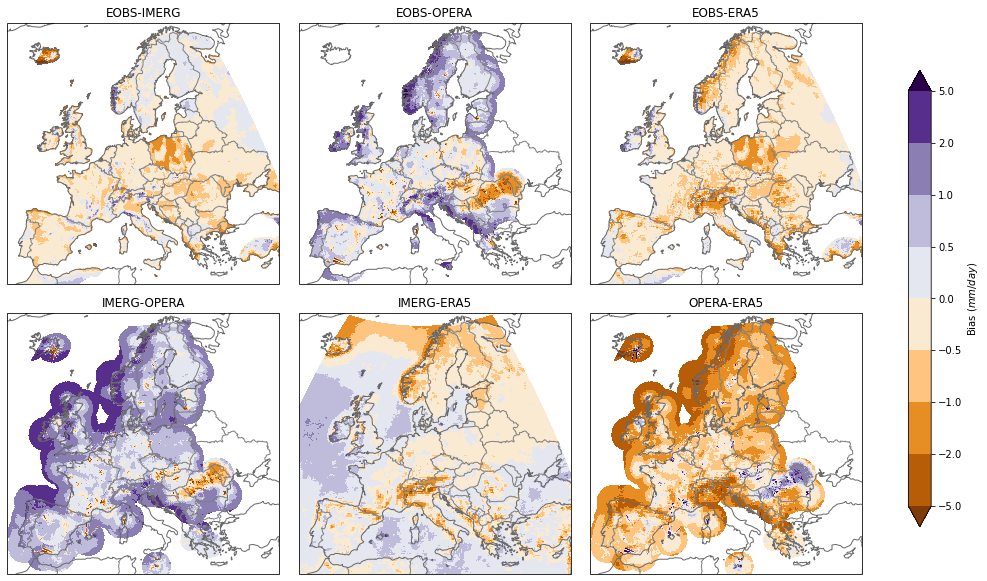

In [42]:
fig0 = bias_panel.tp.plot(
    col="pair", col_wrap=3,
    levels=[-5, -2, -1, -0.5, 0, 0.5, 1, 2, 5],
    cmap="PuOr",
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0)},
    cbar_kwargs={'label': "Bias ($mm/day$)",
                 'orientation': "vertical", 
                 'shrink': 0.7,
                },
    size=6,
    rasterized=True,
)

[ax.coastlines(color="dimgray") for ax in fig0.axes.flatten()]
[ax.add_feature(cfeature.BORDERS, edgecolor='gray') for ax in fig0.axes.flatten()]
[ax.set_extent([-10, 35, 33, 71]) for ax in fig0.axes.flatten()]
[ax.set_title(title) for ax, title in zip(fig0.axes.flatten(), list(("EOBS-IMERG","EOBS-OPERA","EOBS-ERA5","IMERG-OPERA","IMERG-ERA5","OPERA-ERA5")))]
plt.subplots_adjust(hspace=-0.2, wspace=0.07, right=0.75)

In [43]:
fig0.fig.savefig("./plots/biases.pdf", dpi=300)

## Plot availability

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


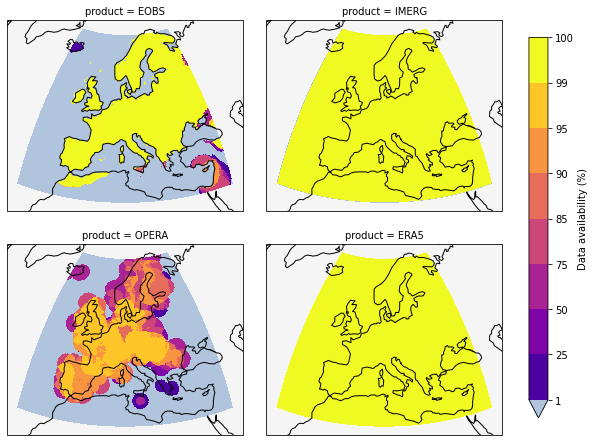

In [44]:
cmap = cm.get_cmap("plasma").copy()
cmap.set_under('lightsteelblue')

fig1 = availability.tp.plot(
    col="product", col_wrap=2,
    transform=ccrs.PlateCarree(),
    levels=[1, 25, 50, 75, 85, 90, 95, 99, 100.000001],
    cbar_kwargs={'label': "Data availability (%)",
                 'orientation': "vertical", 
                 'shrink': 0.7,
                 'aspect': 20},
    subplot_kws={"projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0),
                 "facecolor": "whitesmoke",
                },
    size=5,
    cmap=cmap,
    rasterized=True,
)

[ax.coastlines(color="black") for ax in fig1.axes.flatten()]
plt.subplots_adjust(hspace=-0.3, wspace=0.1, right=0.75)

In [45]:
fig1.fig.savefig("./plots/availability.pdf", dpi=300)

## Plot variance differences

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


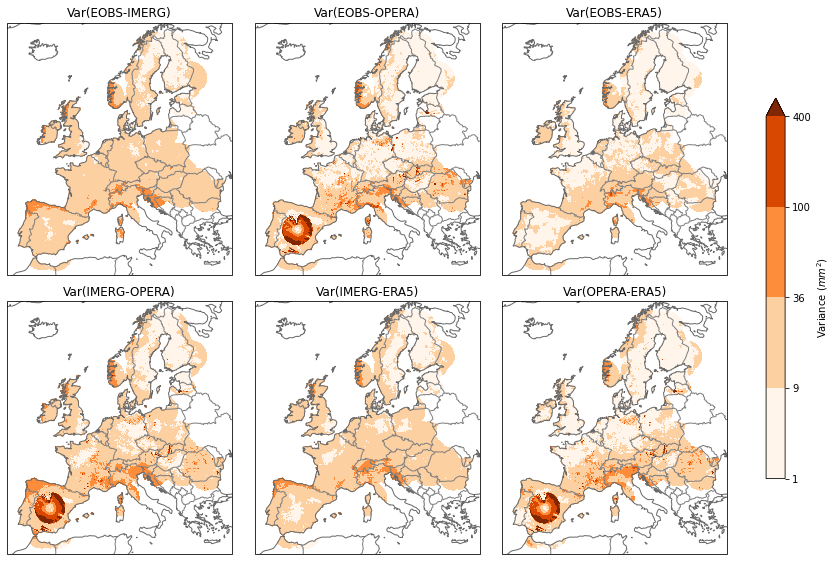

In [46]:
fig5 = var_panel_cc.tp.plot(
    col="pair", col_wrap=3,
    levels=[1, 9, 36, 100, 400],
    cmap="Oranges",
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0)},
    cbar_kwargs={'label': "Variance ($mm^2$)",
                 'orientation': "vertical", 
                 'shrink': 0.7,
                },
    size=5,
    rasterized=True,
)

[ax.coastlines(color="dimgray") for ax in fig5.axes.flatten()]
[ax.add_feature(cfeature.BORDERS, edgecolor='gray') for ax in fig5.axes.flatten()]
[ax.set_extent([-10, 28, 33, 71]) for ax in fig5.axes.flatten()]
[ax.set_title(title) for ax, title in zip(fig5.axes.flatten(), list(("Var(EOBS-IMERG)","Var(EOBS-OPERA)","Var(EOBS-ERA5)","Var(IMERG-OPERA)","Var(IMERG-ERA5)","Var(OPERA-ERA5)")))]
plt.subplots_adjust(hspace=0.05, wspace=0.1, right=0.75)

In [47]:
fig5.fig.savefig("./plots/diff_variance.pdf", dpi=300)

## Plot 4CH errors

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


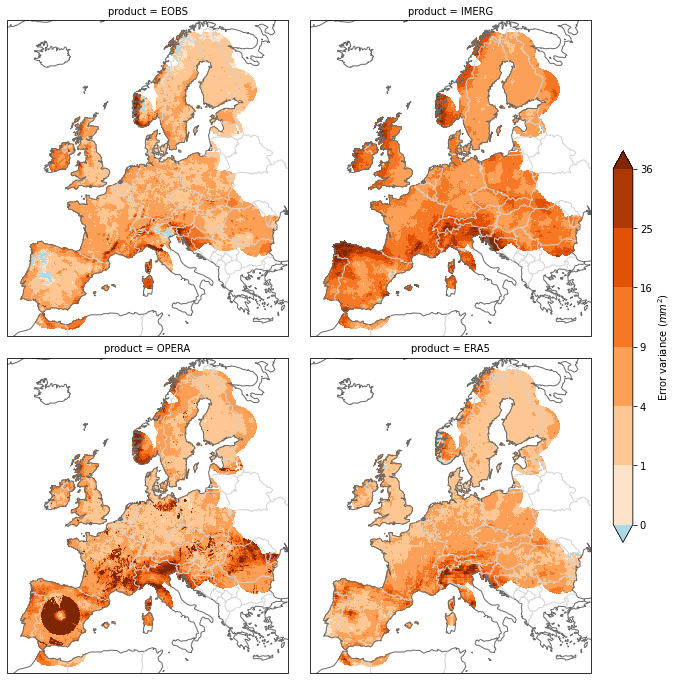

In [48]:
cmap = cm.get_cmap("Oranges").copy()
cmap.set_under('lightblue')
fig6 = (res
    .isel(product=slice(0, 4))
    .plot(
        col="product", col_wrap=2, 
        transform=ccrs.PlateCarree(),
        subplot_kws={
            "projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0)
        },
        cbar_kwargs={
            'label': "Error variance ($mm^2$)",
            'orientation': "vertical", 
            'shrink': 0.6,
        },
        levels=[0, 1, 4, 9, 16, 25, 36],
        size=6,
        cmap=cmap,
        rasterized=True,
    )
)

[ax.coastlines(color="dimgray") for ax in fig6.axes.flatten()]
[ax.add_feature(cfeature.BORDERS, edgecolor='lightgray') for ax in fig6.axes.flatten()]
[ax.set_extent([-10, 28, 33, 71]) for ax in fig6.axes.flatten()]
plt.subplots_adjust(hspace=0.07, wspace=0.04, right=0.76)

In [49]:
fig6.fig.savefig("./plots/4CH_errors.pdf", dpi=300)

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


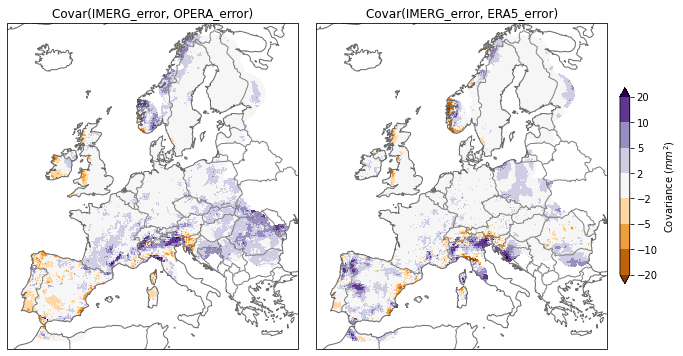

In [50]:
fig7 = (res
    .isel(product=slice(4, 6))
    .plot(
        col="product", col_wrap=2,
        transform=ccrs.PlateCarree(),
        subplot_kws={
            "projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0)
        },
        cbar_kwargs={
            'label': "Covariance ($mm^2$)",
            'orientation': "vertical", 
            'shrink': 0.6,
        },
        levels=[-20, -10, -5, -2, 2, 5, 10, 20],
        size=6,
        cmap="PuOr",
        rasterized=True,
    )
)

[ax.coastlines(color="dimgray") for ax in fig7.axes.flatten()]
[ax.add_feature(cfeature.BORDERS, edgecolor='gray') for ax in fig7.axes.flatten()]
[ax.set_extent([-10, 28, 33, 71]) for ax in fig7.axes.flatten()]
[ax.set_title(title) for ax, title in zip(fig7.axes.flatten(), list(("Covar(IMERG_error, OPERA_error)", "Covar(IMERG_error, ERA5_error)")))]
plt.subplots_adjust(wspace=0.05, right=0.77)

In [51]:
fig7.fig.savefig("./plots/4CH_covariances.pdf", dpi=300)

## Plot best product at each grid point

In [52]:
lookup = xr.DataArray(data=[np.NaN, 1, 2, 3, 4], dims="product", coords={"product": ["nan", "EOBS", "IMERG", "OPERA", "ERA5"]})
best = lookup.sel(product=res.isel(product=slice(0, 4)).idxmin(dim="product").astype("str"))

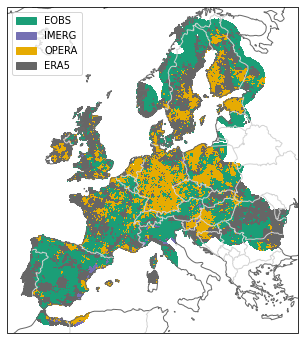

In [53]:
plt.figure(figsize=[12, 6])
figbest = best.plot(
    subplot_kws={"projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0)},
    transform=ccrs.PlateCarree(),
    levels=[0.5, 1.5, 2.5, 3.5, 4.5],
    cmap="Dark2",
    rasterized=True,
    add_colorbar=False,
)

figbest.axes.coastlines(color="dimgray")
figbest.axes.add_feature(cfeature.BORDERS, edgecolor='lightgray')
figbest.axes.set_extent([-10, 28, 33, 71])

cmap = plt.cm.get_cmap('Dark2', 4)
plt.legend([mpatches.Patch(color=cmap(i)) for i in range(4)] ,
           ["EOBS", "IMERG", "OPERA", "ERA5"],
           loc="upper left")

In [54]:
figbest.axes.figure.savefig("./plots/bestproduct.pdf", dpi=300)

## Plot rank of each product

In [55]:
rank = res.isel(product=slice(0, 4)).rank(dim="product")

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


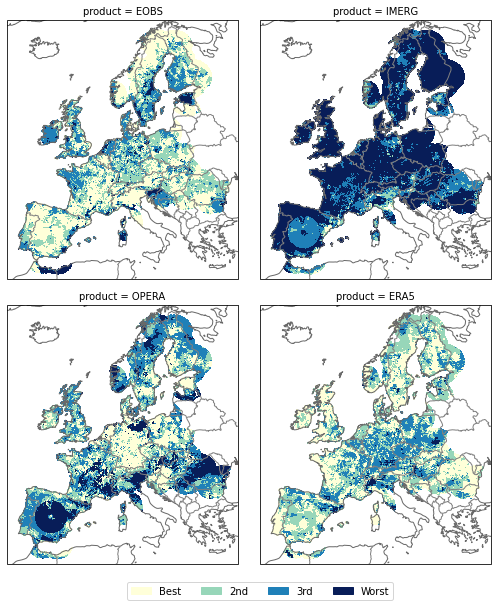

In [56]:
figrank = rank.plot(
    col="product", col_wrap=2,
    subplot_kws={"projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0)},
    transform=ccrs.PlateCarree(),
    levels=[0.5, 1.5, 2.5, 3.5, 4.5],
    cmap="YlGnBu",
    rasterized=True,
    size=5,
    add_colorbar=False,
)

[ax.coastlines(color="dimgray") for ax in figrank.axes.flatten()]
[ax.add_feature(cfeature.BORDERS, edgecolor='gray') for ax in figrank.axes.flatten()]
[ax.set_extent([-10, 28, 33, 71]) for ax in figrank.axes.flatten()]
plt.subplots_adjust(wspace=-0.3, hspace=0.1)

cmap = plt.cm.get_cmap('YlGnBu', 4)
plt.legend([mpatches.Patch(color=cmap(i)) for i in range(4)] ,
           ["Best", "2nd", "3rd", "Worst"],
           loc='upper center', bbox_to_anchor=(0, -0.05), ncol=4)

In [57]:
figrank.fig.savefig("./plots/ranking.pdf", dpi=300)

## Plot 4CH errors for Winter and Summer

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


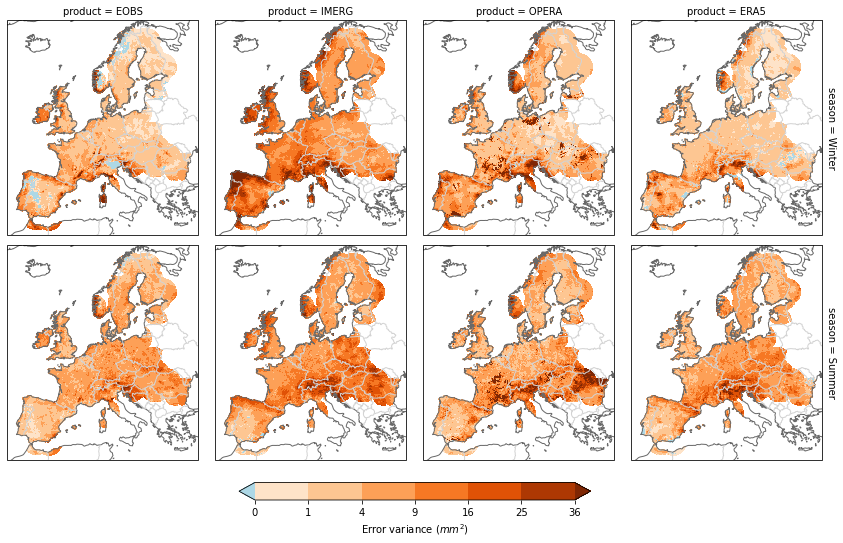

In [58]:
cmap = cm.get_cmap("Oranges").copy()
cmap.set_under('lightblue')

fig9 = (res_seas
    .isel(product=slice(0,4))
    .plot(
        row="season", col="product", 
        transform=ccrs.PlateCarree(),
        subplot_kws={
            "projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0),
        },
        cbar_kwargs={
            'label': "Error variance ($mm^2$)",
            'orientation': "horizontal", 
            'shrink': 0.3,
        },
        levels=[0, 1, 4, 9, 16, 25, 36],
        size=5,
        cmap=cmap,
        rasterized=True,
    )
)

[ax.coastlines(color="dimgray") for ax in fig9.axes.flatten()]
[ax.add_feature(cfeature.BORDERS, edgecolor='lightgray') for ax in fig9.axes.flatten()]
[ax.set_extent([-10, 28, 33, 71]) for ax in fig9.axes.flatten()]
plt.subplots_adjust(hspace=0.05, wspace=-0.62, bottom=0.27)

In [59]:
fig9.fig.savefig("./plots/4CH_winter_summer.pdf", dpi=300)

## Plot 3CH over the ocean

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


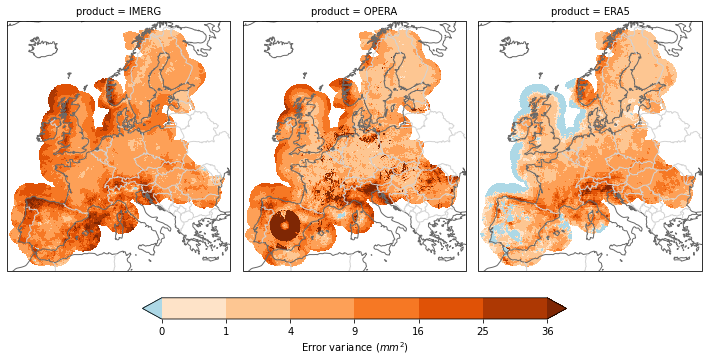

In [60]:
cmap = cm.get_cmap("Oranges").copy()
cmap.set_under('lightblue')

fig10 = res_o.plot(
    col="product", col_wrap=3, 
    transform=ccrs.PlateCarree(),
    subplot_kws={
        "projection": ccrs.NearsidePerspective(central_longitude=10.0, central_latitude=40.0),
    },
    cbar_kwargs={
        'label': "Error variance ($mm^2$)",
        'orientation': "horizontal", 
        'shrink': 0.4,
    },
    levels=[0, 1, 4, 9, 16, 25, 36],
    size=6,
    cmap=cmap,
    rasterized=True,
)

[ax.coastlines(color="dimgray") for ax in fig10.axes.flatten()]
[ax.add_feature(cfeature.BORDERS, edgecolor='lightgray') for ax in fig10.axes.flatten()]
[ax.set_extent([-10, 28, 33, 71]) for ax in fig10.axes.flatten()]
plt.subplots_adjust(wspace=-0.6, bottom=0.3)

In [61]:
fig10.fig.savefig("./plots/3CH_ocean.pdf", dpi=300)